In [57]:
import torch
import matplotlib.pyplot as plt
from torch import nn

In [58]:
# the numerical equation
# y = 0.05 + sum_over_d(0.01 * x(d)) + epsilon

n_train, n_test, num_inputs, batch_size = 20,100,200,5
true_w = torch.ones((num_inputs,1)) * 0.01
true_bias = 0.05
X =  torch.normal(0,1,(n_train+n_test,num_inputs))
y = torch.matmul(X , true_w) + true_bias
y += torch.normal(0,0.01,(y.shape))

In [59]:
y.shape, X.shape

(torch.Size([120, 1]), torch.Size([120, 200]))

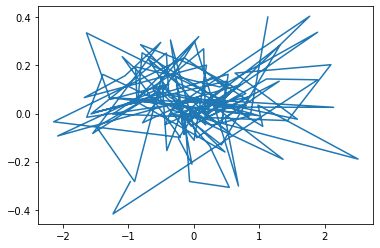

In [60]:
plt.plot(X[:,1], y)

In [61]:
# now that we have the features we needto train the dataset and create data iter

train_dataset = torch.utils.data.TensorDataset(*(X[:n_train], y[:n_train]))
test_dataset =torch.utils.data.TensorDataset(*(X[n_train+1:], y[n_train+1:]))

In [62]:
train_iter = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

In [63]:
test_iter = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

## Implementation from scratch

In [64]:
def init_params():
    w = torch.normal(0,1,size=(num_inputs,1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return w,b

In [65]:
def l2_penalty(w):
    return torch.sum(w.pow(2))/2

In [66]:
def linreg(X, w, b):
    return torch.matmul(X,w) + b

In [67]:
def squared_loss(y_hat, y):
    return 0.5 * (y_hat - y) ** 2
    

In [68]:
def evaluate_loss(net, data_iter, loss,w,b, ttext):
    current_loss = 0
    current_number = 0
#     print(ttext)
    with torch.no_grad():
        for X, y in data_iter:
            y_hat = net(X,w,b)
#             print(y_hat.shape, y.shape)
            l = loss(y_hat, y)
#             print(l)
            current_loss += l.sum()
            current_number += len(y)
    return current_loss/current_number
        
        

In [69]:
def train(lambd):
    w,b = init_params()
    net = linreg
    loss = squared_loss
    
    num_epochs = 100
    learning_rate = 0.003
    
    optimizer = torch.optim.SGD([w,b], lr=learning_rate)
    
    train_loss_array = []
    test_loss_array = []
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X,w,b), y) - lambd * l2_penalty(w)
            optimizer.zero_grad()
            l.sum().backward()
    
            optimizer.step()

        train_loss_array.append(evaluate_loss(net, train_iter,loss,w,b,"train"))
        test_loss_array.append(evaluate_loss(net, test_iter, loss,w,b, "test"))

    print("l2 norm of w: ", torch.norm(w).item())
    
    plt.plot(range(0, num_epochs), train_loss_array)
    plt.plot(range(0, num_epochs), test_loss_array)
    plt.show()
            
        
            
    
    

l2 norm of w:  13.90286636352539


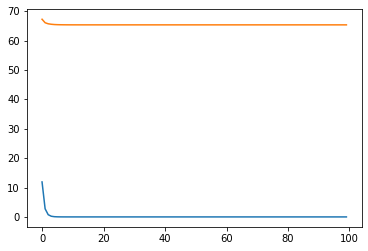

In [70]:
train(lambd=0)

l2 norm of w:  625555264.0


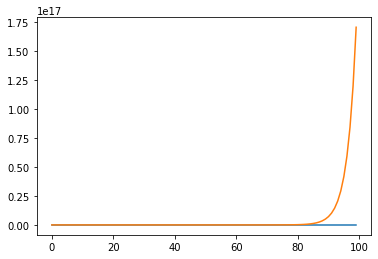

In [71]:
train(lambd=3)